<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/src/notebooks/k_means/cluster_yolo_images_by_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for loading/processing the images
from keras.preprocessing.image import load_img
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras import layers

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# image display
import IPython.display as display
from PIL import Image

# for everything else
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import tensorflow as tf
import cv2

!pip install ultralytics
from ultralytics import YOLO

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [18]:
path_to_instance_segmentation_model = '/content/gdrive/MyDrive/Cat images/models/feral-cat-segmentation.v1i.yolov8/200-epochs-/weights/best.pt'
path_to_segmented_images = '/content/segmented_cats'

In [19]:
instance_segmentation_model = YOLO(path_to_instance_segmentation_model)  # load the feral cat instance segmentation model

In [6]:
# Parameters for feature clustering model
INPUT_SHAPE = (224,224, 3) ## Pixel size of images accepted by VGG, in each of 3 channels
IMG_SIZE = INPUT_SHAPE[:2]

In [ ]:
# load VGG model for image clustering
image_cluster_model = VGG16()
# remove the output layer
image_cluster_model = Model(inputs=image_cluster_model.inputs, outputs=image_cluster_model.layers[-2].output)

553467096/553467096 [==============================] - 42s 0us/step


In [ ]:
def extract_features(file, model, img_size=IMG_SIZE):
    # load the image as a 224x224 array
    img = load_img(file, target_size=img_size)
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = np.expand_dims(img, axis=0)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
# from https://github.com/arvkevi/kneed/blob/main/kneed/knee_locator.py
# Implementation of Kneedle algorithm at repo https://github.com/arvkevi/kneed
# for theoretical discussion of Kneedle, see https://towardsdatascience.com/detecting-knee-elbow-points-in-a-graph-d13fc517a63c
import numpy as np
from scipy import interpolate
from scipy.signal import argrelextrema
from typing import Tuple, Optional, Iterable

VALID_CURVE = ["convex", "concave"]
VALID_DIRECTION = ["increasing", "decreasing"]

try:
    import matplotlib.pyplot as plt
except ImportError:
    _has_matplotlib = False
    _matplotlib_not_found_err = ModuleNotFoundError(
        "This function needs Matplotlib to be executed. Please run command `pip install kneed[plot]` "
    )
else:
    _has_matplotlib = True


class KneeLocator(object):
    """
    Once instantiated, this class attempts to find the point of maximum
    curvature on a line. The knee is accessible via the `.knee` attribute.

    :param x: x values, must be the same length as y.
    :type x: 1D array of shape (`number_of_y_values`,) or list
    :param y: y values, must be the same length as x.
    :type y: 1D array of shape (`number_of_y_values`,) or list
    :param S: Sensitivity, the number of minimum number of data points below the local distance maximum before calling a knee. The original paper suggests default of 1.0
    :type S: float
    :param curve: If 'concave', algorithm will detect knees. If 'convex', it
        will detect elbows.
    :type curve: str
    :param direction: one of {"increasing", "decreasing"}
    :type direction: str
    :param interp_method: one of {"interp1d", "polynomial"}
    :type interp_method: str
    :param online: kneed will correct old knee points if True, will return first knee if False
    :type online: bool
    :param polynomial_degree: The degree of the fitting polynomial. Only used when interp_method="polynomial". This argument is passed to numpy polyfit `deg` parameter.
    :type polynomial_degree: int
    :ivar x: x values.
    :vartype x: array-like
    :ivar y: y values.
    :vartype y: array-like
    :ivar S: Sensitivity, original paper suggests default of 1.0
    :vartype S: integer
    :ivar curve: If 'concave', algorithm will detect knees. If 'convex', it
        will detect elbows.
    :vartype curve: str
    :ivar direction: one of {"increasing", "decreasing"}
    :vartype direction: str
    :ivar interp_method: one of {"interp1d", "polynomial"}
    :vartype interp_method: str
    :ivar online: kneed will correct old knee points if True, will return first knee if False
    :vartype online: str
    :ivar polynomial_degree: The degree of the fitting polynomial. Only used when interp_method="polynomial". This argument is passed to numpy polyfit `deg` parameter.
    :vartype polynomial_degree: int
    :ivar N: The number of `x` values in the
    :vartype N: integer
    :ivar all_knees: A set containing all the x values of the identified knee points.
    :vartype all_knees: set
    :ivar all_norm_knees: A set containing all the normalized x values of the identified knee points.
    :vartype all_norm_knees: set
    :ivar all_knees_y: A list containing all the y values of the identified knee points.
    :vartype all_knees_y: list
    :ivar all_norm_knees_y: A list containing all the normalized y values of the identified knee points.
    :vartype all_norm_knees_y: list
    :ivar Ds_y: The y values from the fitted spline.
    :vartype Ds_y: numpy array
    :ivar x_normalized: The normalized x values.
    :vartype x_normalized: numpy array
    :ivar y_normalized: The normalized y values.
    :vartype y_normalized: numpy array
    :ivar x_difference: The x values of the difference curve.
    :vartype x_difference: numpy array
    :ivar y_difference: The y values of the difference curve.
    :vartype y_difference: numpy array
    :ivar maxima_indices: The indices of each of the maxima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar maxima_indices: The indices of each of the maxima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar x_difference_maxima: The x values from the difference curve where the local maxima are located.
    :vartype x_difference_maxima: numpy array
    :ivar y_difference_maxima: The y values from the difference curve where the local maxima are located.
    :vartype y_difference_maxima: numpy array
    :ivar minima_indices: The indices of each of the minima on the difference curve.
    :vartype minima_indices: numpy array
    :ivar minima_indices: The indices of each of the minima on the difference curve.
    :vartype maxima_indices: numpy array
    :ivar x_difference_minima: The x values from the difference curve where the local minima are located.
    :vartype x_difference_minima: numpy array
    :ivar y_difference_minima: The y values from the difference curve where the local minima are located.
    :vartype y_difference_minima: numpy array
    :ivar Tmx: The y values that correspond to the thresholds on the difference curve for determining the knee point.
    :vartype Tmx: numpy array
    :ivar knee: The x value of the knee point. None if no knee/elbow was detected.
    :vartype knee: float
    :ivar knee_y: The y value of the knee point. None if no knee/elbow was detected
    :vartype knee_y: float
    :ivar norm_knee: The normalized x value of the knee point. None if no knee/elbow was detected
    :vartype norm_knee: float
    :ivar norm_knee_y: The normalized y value of the knee point. None if no knee/elbow was detected
    :vartype norm_knee_y: float
    :ivar all_knees: The x values of all the identified knee points.
    :vartype all_knees: set
    :ivar all_knees_y: The y values of all the identified knee points.
    :vartype all_knees: set
    :ivar all_norm_knees: The normalized x values of all the identified knee points.
    :vartype all_norm_knees: set
    :ivar all_norm_knees_y: The normalized y values of all the identified knee points.
    :vartype all_norm_knees: set
    :ivar elbow: The x value of the elbow point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype elbow: float
    :ivar elbow_y: The y value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype elbow_y: float
    :ivar norm_elbow: The normalized x value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype norm_knee: float
    :ivar norm_elbow_y: The normalized y value of the knee point (elbow and knee are interchangeable). None if no knee/elbow was detected
    :vartype norm_elbow_y: float
    :ivar all_elbows: The x values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_elbows: set
    :ivar all_elbows_y: The y values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_elbows: set
    :ivar all_norm_elbows: The normalized x values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_norm_elbows: set
    :ivar all_norm_elbows_y: The normalized y values of all the identified knee points (elbow and knee are interchangeable).
    :vartype all_norm_elbows: set
    """

    def __init__(
        self,
        x: Iterable[float],
        y: Iterable[float],
        S: float = 1.0,
        curve: str = "concave",
        direction: str = "increasing",
        interp_method: str = "interp1d",
        online: bool = False,
        polynomial_degree: int = 7,
    ):
        # Step 0: Raw Input
        self.x = np.array(x)
        self.y = np.array(y)
        self.curve = curve
        self.direction = direction
        self.N = len(self.x)
        self.S = S
        self.all_knees = set()
        self.all_norm_knees = set()
        self.all_knees_y = []
        self.all_norm_knees_y = []
        self.online = online
        self.polynomial_degree = polynomial_degree

        # I'm implementing Look Before You Leap (LBYL) validation for direction
        # and curve arguments. This is not preferred in Python. The motivation
        # is that the logic inside the conditional once y_difference[j] is less
        # than threshold in find_knee() could have been evaluated improperly if
        # they weren't one of convex, concave, increasing, or decreasing,
        # respectively.
        valid_curve = self.curve in VALID_CURVE
        valid_direction = self.direction in VALID_DIRECTION
        if not all((valid_curve, valid_direction)):
            raise ValueError(
                "Please check that the curve and direction arguments are valid."
            )

        # Step 1: fit a smooth line
        if interp_method == "interp1d":
            uspline = interpolate.interp1d(self.x, self.y)
            self.Ds_y = uspline(self.x)
        elif interp_method == "polynomial":
            p = np.poly1d(np.polyfit(x, y, self.polynomial_degree))
            self.Ds_y = p(x)
        else:
            raise ValueError(
                "{} is an invalid interp_method parameter, use either 'interp1d' or 'polynomial'".format(
                    interp_method
                )
            )

        # Step 2: normalize values
        self.x_normalized = self.__normalize(self.x)
        self.y_normalized = self.__normalize(self.Ds_y)

        # Step 3: Calculate the Difference curve
        self.y_normalized = self.transform_y(
            self.y_normalized, self.direction, self.curve
        )
        # normalized difference curve
        self.y_difference = self.y_normalized - self.x_normalized
        self.x_difference = self.x_normalized.copy()

        # Step 4: Identify local maxima/minima
        # local maxima
        self.maxima_indices = argrelextrema(self.y_difference, np.greater_equal)[0]
        self.x_difference_maxima = self.x_difference[self.maxima_indices]
        self.y_difference_maxima = self.y_difference[self.maxima_indices]

        # local minima
        self.minima_indices = argrelextrema(self.y_difference, np.less_equal)[0]
        self.x_difference_minima = self.x_difference[self.minima_indices]
        self.y_difference_minima = self.y_difference[self.minima_indices]

        # Step 5: Calculate thresholds
        self.Tmx = self.y_difference_maxima - (
            self.S * np.abs(np.diff(self.x_normalized).mean())
        )

        # Step 6: find knee
        self.knee, self.norm_knee = self.find_knee()

        # Step 7: If we have a knee, extract data about it
        self.knee_y = self.norm_knee_y = None
        if self.knee:
            self.knee_y = self.y[self.x == self.knee][0]
            self.norm_knee_y = self.y_normalized[self.x_normalized == self.norm_knee][0]

    @staticmethod
    def __normalize(a: Iterable[float]) -> Iterable[float]:
        """normalize an array
        :param a: The array to normalize
        """
        return (a - min(a)) / (max(a) - min(a))

    @staticmethod
    def transform_y(y: Iterable[float], direction: str, curve: str) -> float:
        """transform y to concave, increasing based on given direction and curve"""
        # convert elbows to knees
        if direction == "decreasing":
            if curve == "concave":
                y = np.flip(y)
            elif curve == "convex":
                y = y.max() - y
        elif direction == "increasing" and curve == "convex":
            y = np.flip(y.max() - y)

        return y

    def find_knee(
        self,
    ):
        """This function is called when KneeLocator is instantiated. It identifies the knee value and sets the instance attributes."""
        if not self.maxima_indices.size:
            # No local maxima found in the difference curve
            # The line is probably not polynomial, try plotting
            # the difference curve with plt.plot(knee.x_difference, knee.y_difference)
            # Also check that you aren't mistakenly setting the curve argument
            return None, None
        # placeholder for which threshold region i is located in.
        maxima_threshold_index = 0
        minima_threshold_index = 0
        traversed_maxima = False
        # traverse the difference curve
        for i, x in enumerate(self.x_difference):
            # skip points on the curve before the the first local maxima
            if i < self.maxima_indices[0]:
                continue

            j = i + 1

            # reached the end of the curve
            if i == (len(self.x_difference) - 1):
                break

            # if we're at a local max, increment the maxima threshold index and continue
            if (self.maxima_indices == i).any():
                threshold = self.Tmx[maxima_threshold_index]
                threshold_index = i
                maxima_threshold_index += 1
            # values in difference curve are at or after a local minimum
            if (self.minima_indices == i).any():
                threshold = 0.0
                minima_threshold_index += 1

            if self.y_difference[j] < threshold:
                if self.curve == "convex":
                    if self.direction == "decreasing":
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]
                    else:
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[threshold_index]

                elif self.curve == "concave":
                    if self.direction == "decreasing":
                        knee = self.x[-(threshold_index + 1)]
                        norm_knee = self.x_normalized[threshold_index]
                    else:
                        knee = self.x[threshold_index]
                        norm_knee = self.x_normalized[threshold_index]

                # add the y value at the knee
                y_at_knee = self.y[self.x == knee][0]
                y_norm_at_knee = self.y_normalized[self.x_normalized == norm_knee][0]
                if knee not in self.all_knees:
                    self.all_knees_y.append(y_at_knee)
                    self.all_norm_knees_y.append(y_norm_at_knee)

                # now add the knee
                self.all_knees.add(knee)
                self.all_norm_knees.add(norm_knee)

                # if detecting in offline mode, return the first knee found
                if self.online is False:
                    return knee, norm_knee

        if self.all_knees == set():
            # No knee was found
            return None, None

        return knee, norm_knee

    def plot_knee_normalized(
        self,
        figsize: Optional[Tuple[int, int]] = None,
        title: str = "Normalized Knee Point",
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
    ):
        """Plot the normalized curve, the difference curve (x_difference, y_normalized) and the knee, if it exists.

        :param figsize: Optional[Tuple[int, int]
            The figure size of the plot. Example (12, 8)
        :param title: str
            Title of the visualization, defaults to "Normalized Knee Point"
        :param xlabel: Optional[str]
            X-axis label
        :param ylabel: Optional[str]
            y-axis label
        :return: NoReturn
        """
        if not _has_matplotlib:
            raise _matplotlib_not_found_err

        if figsize is None:
            figsize = (6, 6)

        plt.figure(figsize=figsize)
        plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.plot(self.x_normalized, self.y_normalized, "b", label="normalized curve")
        plt.plot(self.x_difference, self.y_difference, "r", label="difference curve")
        plt.xticks(
            np.arange(self.x_normalized.min(), self.x_normalized.max() + 0.1, 0.1)
        )
        plt.yticks(
            np.arange(self.y_difference.min(), self.y_normalized.max() + 0.1, 0.1)
        )

        plt.vlines(
            self.norm_knee,
            plt.ylim()[0],
            plt.ylim()[1],
            linestyles="--",
            label="knee/elbow",
        )
        plt.legend(loc="best")

    def plot_knee(
        self,
        figsize: Optional[Tuple[int, int]] = None,
        title: str = "Knee Point",
        xlabel: Optional[str] = None,
        ylabel: Optional[str] = None,
    ):
        """
        Plot the curve and the knee, if it exists

        :param figsize: Optional[Tuple[int, int]
            The figure size of the plot. Example (12, 8)
        :param title: str
            Title of the visualization, defaults to "Knee Point"
        :param xlabel: Optional[str]
            X-axis label
        :param ylabel: Optional[str]
            y-axis label
        :return: NoReturn
        """
        if not _has_matplotlib:
            raise _matplotlib_not_found_err

        if figsize is None:
            figsize = (6, 6)

        plt.figure(figsize=figsize)
        plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.plot(self.x, self.y, "b", label="data")
        plt.vlines(
            self.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", label="knee/elbow"
        )
        plt.legend(loc="best")

    # Niceties for users working with elbows rather than knees
    @property
    def elbow(self):
        return self.knee

    @property
    def norm_elbow(self):
        return self.norm_knee

    @property
    def elbow_y(self):
        return self.knee_y

    @property
    def norm_elbow_y(self):
        return self.norm_knee_y

    @property
    def all_elbows(self):
        return self.all_knees

    @property
    def all_norm_elbows(self):
        return self.all_norm_knees

    @property
    def all_elbows_y(self):
        return self.all_knees_y

    @property
    def all_norm_elbows_y(self):
        return self.all_norm_knees_y

In [ ]:
import zipfile
!unzip /content/segmented_cats.zip

In [ ]:


# We're reading raw images from the files containing the extracted segmented images, so transform them
# by normalizing the pixels and resizing the image as expected by the VGG model
transformer_nn = tf.keras.Sequential([
        layers.Resizing(244,244),
        layers.Rescaling(1./255)])




1/1 [==============================] - 0s 21ms/step
Total of 0 unusable images and 108 usable images
1/1 [==============================] - 0s 23ms/step


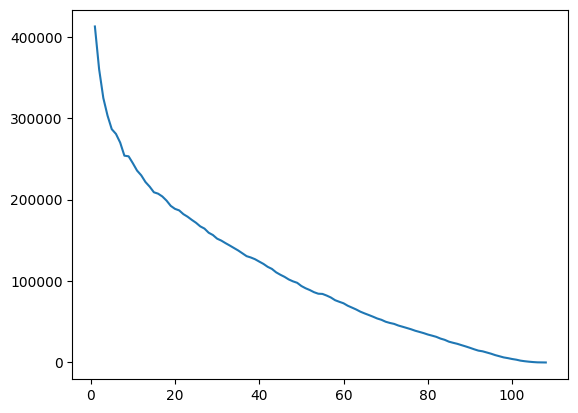

In [ ]:
# Compile a list of all the extracted segmented images
import glob
image_paths = []
# get all image paths in folder with extracted segmented images
for path in glob.glob(os.path.join(path_to_segmented_images, '*.jpeg')):
    image_paths.append(path)
# sort image_path
image_paths.sort()

# Extract the features from each test case image
data = {}
for segmented_image_file in image_paths:
  feature = extract_features(os.path.join(path_to_segmented_images, segmented_image_file), image_cluster_model)
  data[segmented_image_file] = feature

# Get list of filenames
filenames = np.array(list(data.keys()))
# Get a list of just the features
feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)

x_values = []
y_values = []

pca = PCA(n_components = min(100, len(filenames)), random_state=22)
pca.fit(feat)

for i in range(len(filenames)):
  kmeans = KMeans(n_clusters=i+1, n_init='auto', random_state=22)
  x = pca.transform(feat)
  kmeans.fit(x)
  x = x_values.append(i+1)
  y = y_values.append(kmeans.inertia_)
plt.plot(x_values, y_values)

In [ ]:
sensitivity = [1, 2, 4, 8, 16, 32]
elbows = []
for s in sensitivity:
  kn = KneeLocator(x_values, y_values, curve='convex', direction='decreasing', S=s)
  elbows.append(kn.elbow)
elbows

[30, 30, 50, 50, 50, 50]

In [ ]:
# Cluster based on the optimal number of cluster when sensitivity is 1
kmeans = KMeans(n_clusters=elbows[2], n_init="auto", random_state=22)
kmeans.fit(feat)
images_df = pd.DataFrame(data=image_paths, columns=['segmented_image_filename'])
images_df['cluster_id'] = kmeans.labels_

In [ ]:
# for i in range(len(df)):
#  idx = df.index[df['cropped_image_filename'] == images_df['cropped_image_filename'].iloc[i]]
#  df.loc[idx, 'cluster_id'] = images_df['cluster_id'].iloc[i]



In [ ]:
import math
def plot_cluster(cluster_id):
  cluster_filenames = images_df[images_df['cluster_id'] == cluster_id]
  file_count = len(cluster_filenames)
  columns = 2
  rows = math.ceil(file_count / columns)
  fig = plt.figure(figsize=(10,8))
  for i in range(file_count):
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.imshow(imread(os.path.join(path_to_segmented_images, cluster_filenames['segmented_image_filename'].iloc[i])))
    plt.axis('off')
    plt.title('Index {}'.format(cluster_filenames.index[i]))
  plt.show()



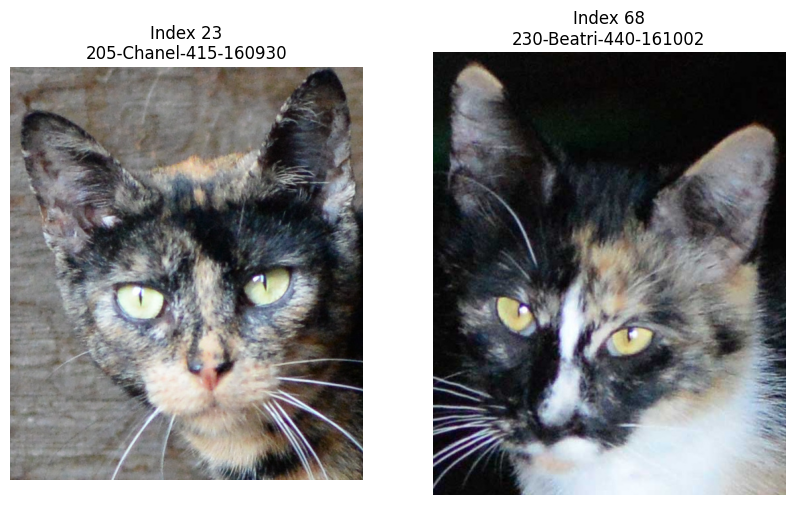

In [ ]:
plot_cluster(0)

Similarity Score: 55.163%


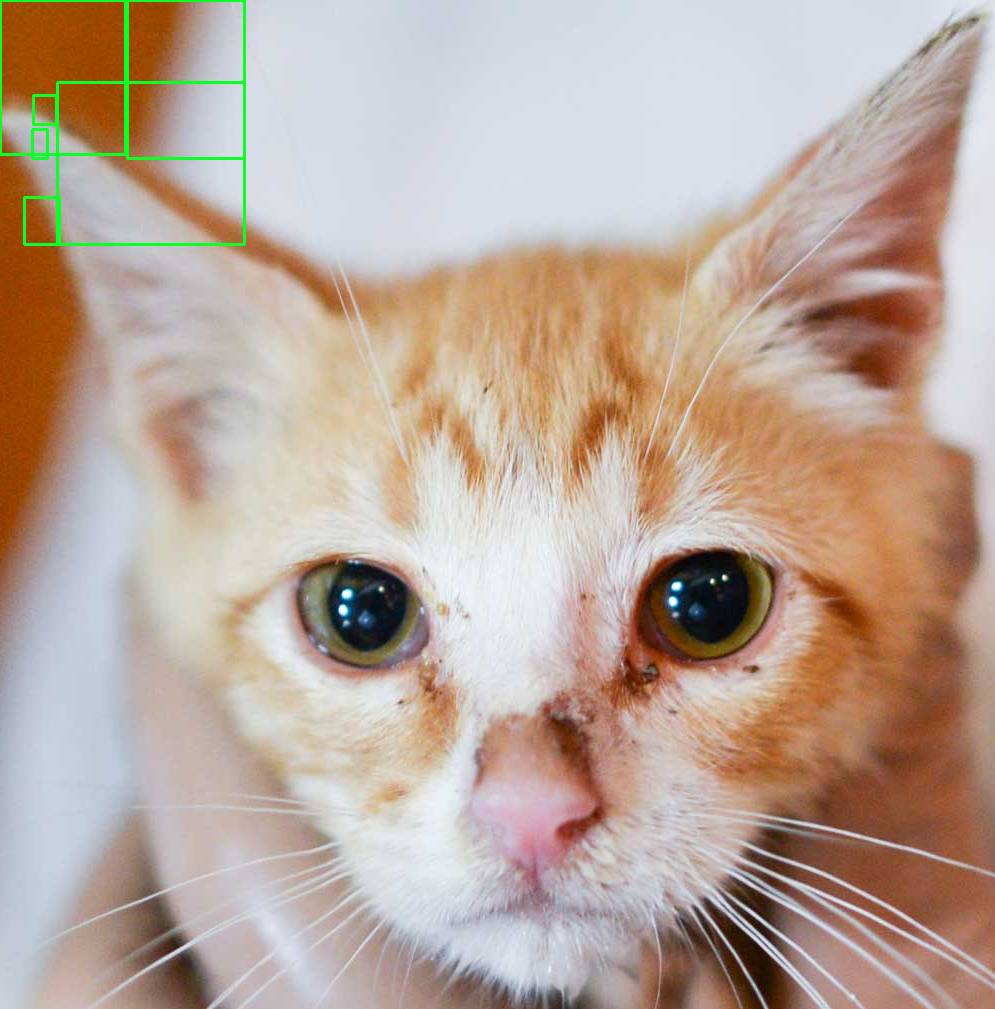

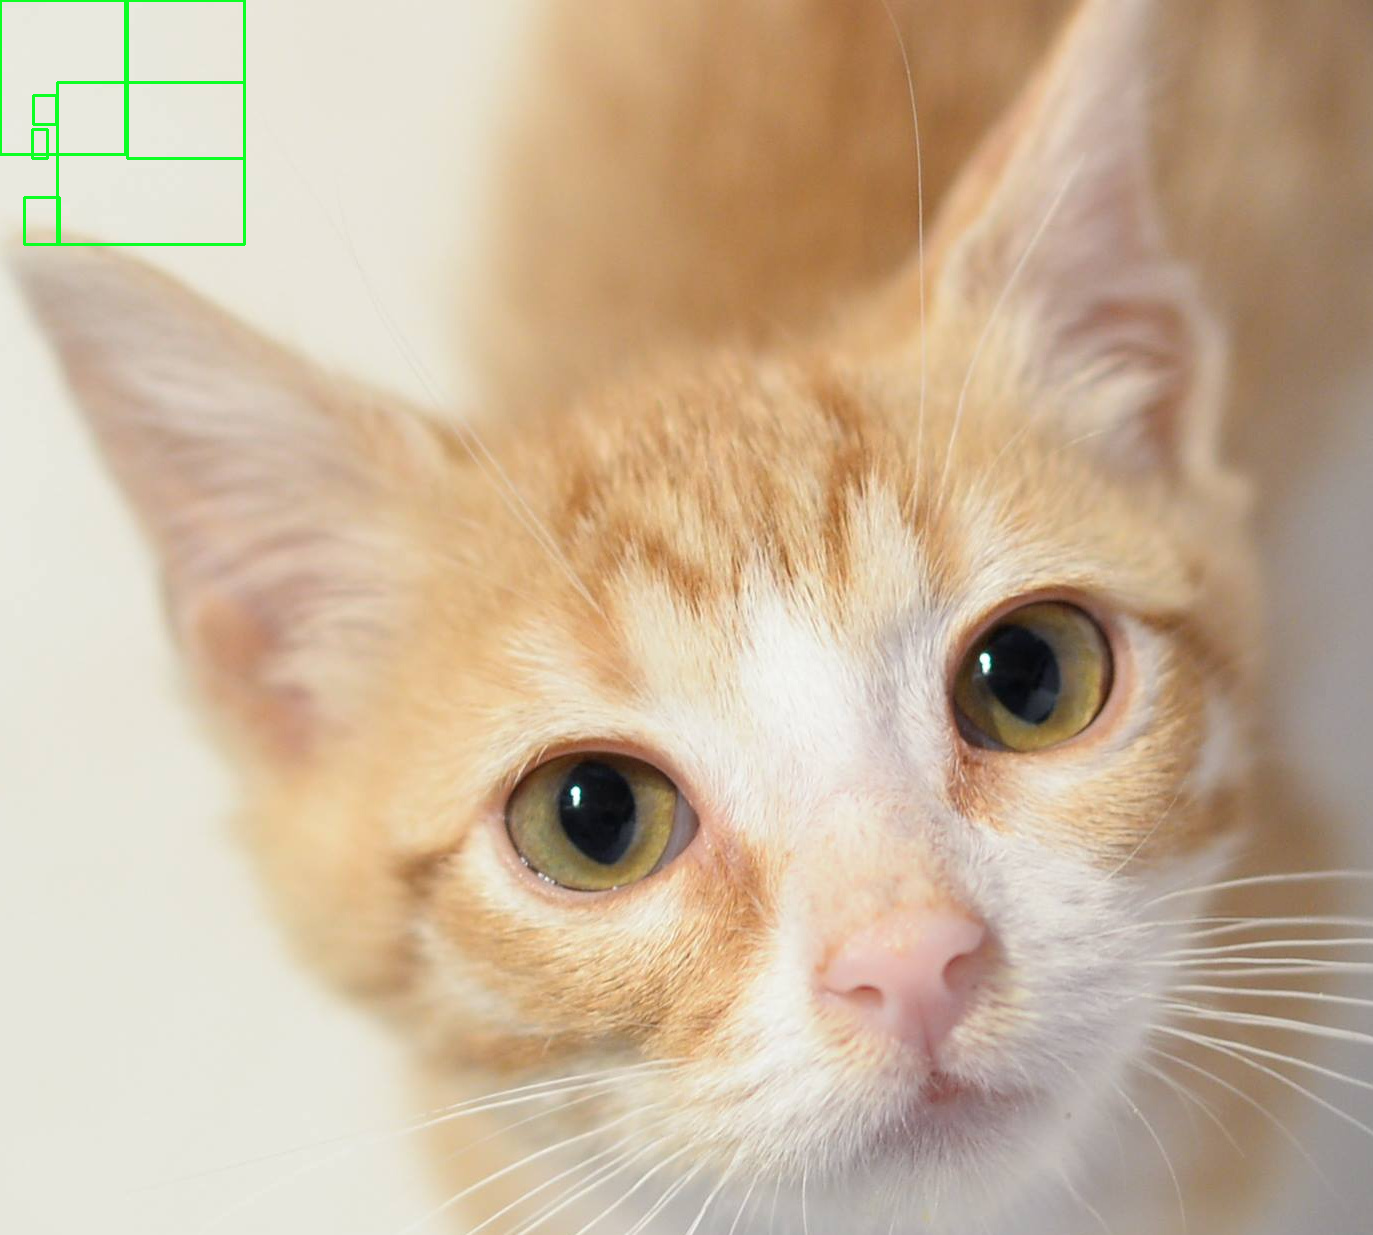

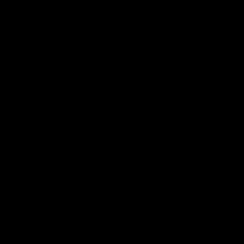

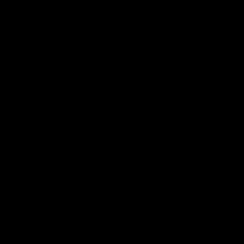

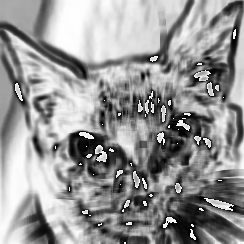

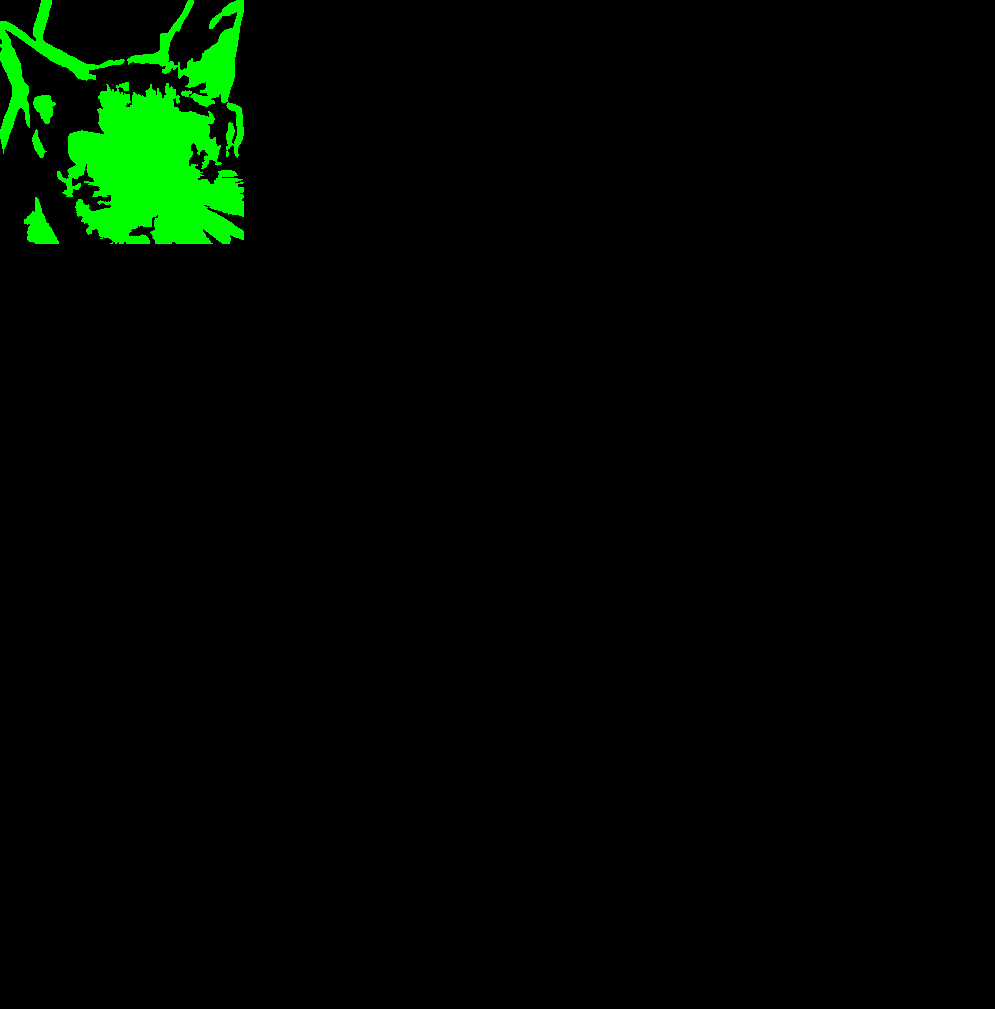

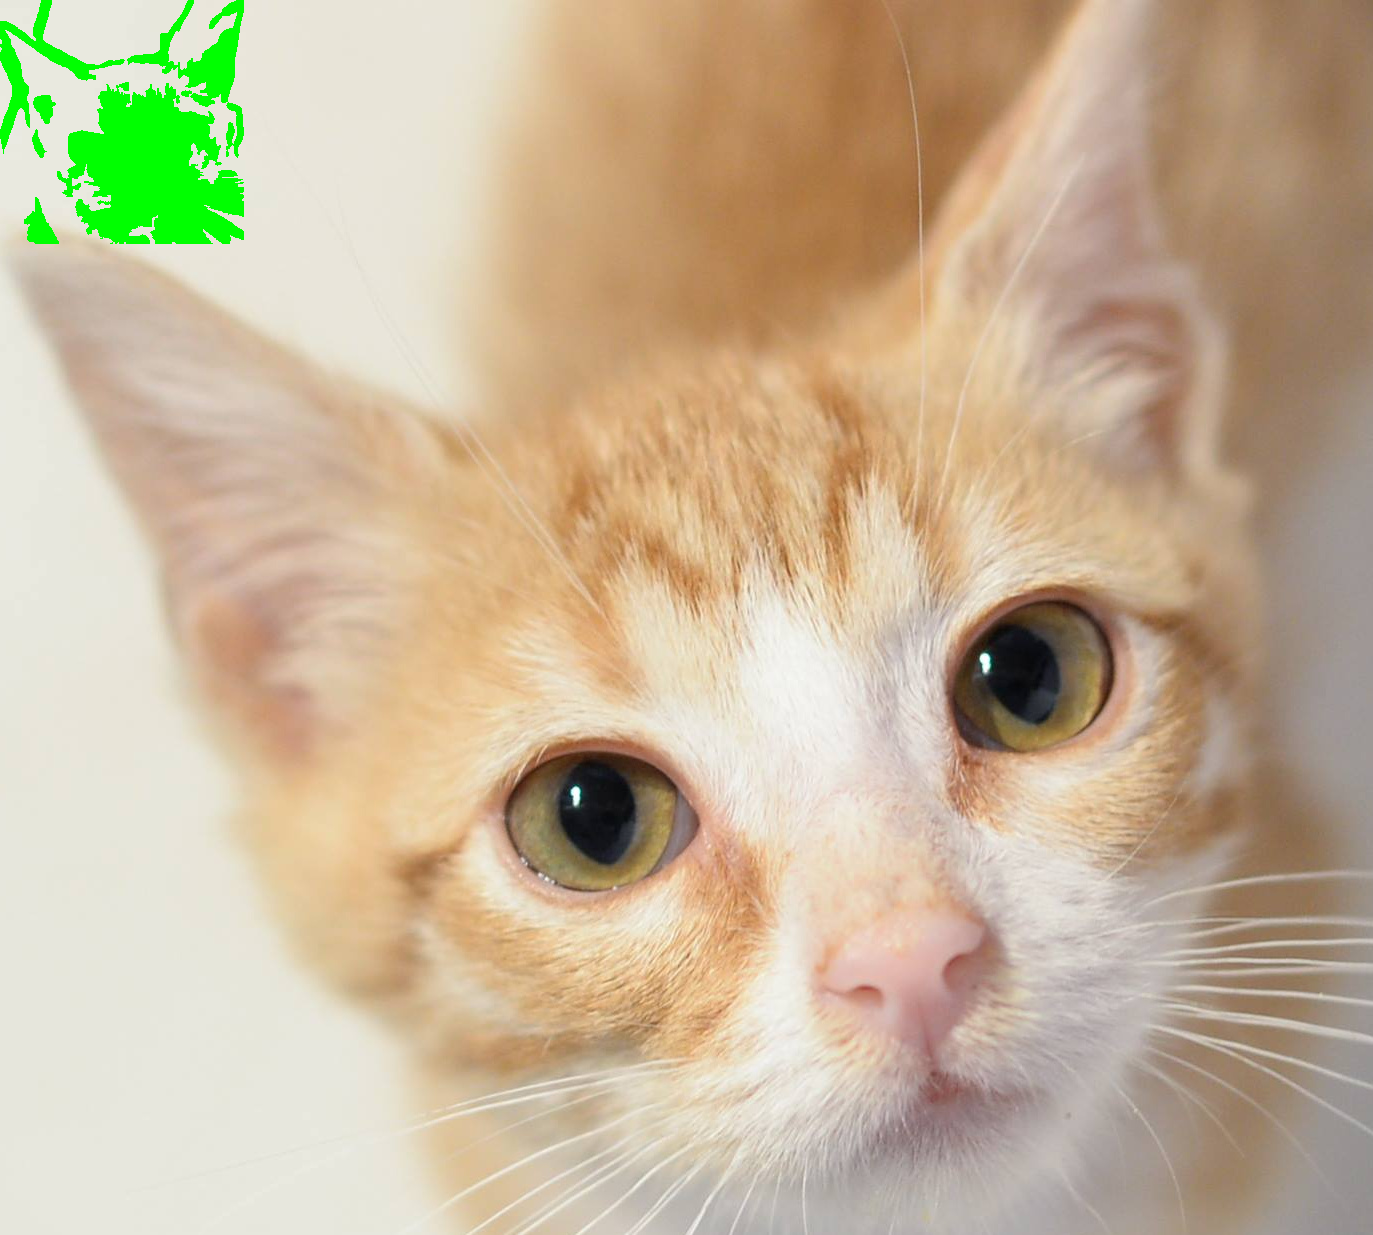

In [ ]:
# See https://stackoverflow.com/questions/11541154/checking-images-for-similarity-with-opencv

from skimage.metrics import structural_similarity
from google.colab.patches import cv2_imshow

transformer1_nn = tf.keras.Sequential([
        layers.Resizing(244,244)])

first = cv2.imread(os.path.join(path_to_cropped_and_classified_images, 'img28.jpg'))
second = cv2.imread(os.path.join(path_to_cropped_and_classified_images, 'img38.jpg'))
# Transform the image by resizing and rescaling
first_resized = transformer_nn(first)
# Convert tensor to numpy array
first_resized = first_resized.numpy()
second_resized = transformer_nn(second)
second_resized = second_resized.numpy()

# Convert images to grayscale
first_gray = cv2.cvtColor(first_resized, cv2.COLOR_BGR2GRAY)
second_gray = cv2.cvtColor(second_resized, cv2.COLOR_BGR2GRAY)

# Compute SSIM between two images
score, diff = structural_similarity(first_gray, second_gray, full=True)
print("Similarity Score: {:.3f}%".format(score * 100))

# The diff image contains the actual image differences between the two images
# and is represented as a floating point data type so we must convert the array
# to 8-bit unsigned integers in the range [0,255] before we can use it with OpenCV
diff = (diff * 255).astype("uint8")

# Threshold the difference image, followed by finding contours to
# obtain the regions that differ between the two images
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# Highlight differences
mask = np.zeros(first.shape, dtype='uint8')
filled = second.copy()

for c in contours:
    area = cv2.contourArea(c)
    if area > 100:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(first, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.rectangle(second, (x, y), (x + w, y + h), (36,255,12), 2)
        cv2.drawContours(mask, [c], 0, (0,255,0), -1)
        cv2.drawContours(filled, [c], 0, (0,255,0), -1)

# cv2_imshow(first)
# cv2_imshow(second)
# cv2_imshow(first_resized) # first image
# cv2_imshow(second_resized) # second image
# cv2_imshow(diff) # difference image
# cv2_imshow(mask) # image mask
# cv2_imshow(filled) # filled
# cv2.waitKey()

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.1 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=0f4e1f5c6850fb37eb14230fefae099ddbb62009ba694d631f44ebbfd94fc650
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

# Next we compute the embeddings
# To encode an image, you can use the following code:
# from PIL import Image
# encoded_image = model.encode(Image.open(filepath))
image_names = list(glob.glob(os.path.join(path_to_cropped_and_classified_images, '*.jpg')))
print("Images:", len(image_names))
encoded_image = model.encode([Image.open(os.path.join(path_to_cropped_and_classified_images, filepath)) for filepath in image_names], batch_size=128, convert_to_tensor=True, show_progress_bar=True)

# Now we run the clustering algorithm. This function compares images against
# all other images and returns a list with the pairs that have the highest
# cosine similarity score
processed_images = util.paraphrase_mining_embeddings(encoded_image)
NUM_SIMILAR_IMAGES = 10

# =================
# DUPLICATES
# =================
print('Finding duplicate images...')
# Filter list for duplicates. Results are triplets (score, image_id1, image_id2) and is scorted in decreasing order
# A duplicate image will have a score of 1.00
# It may be 0.9999 due to lossy image compression (.jpg)
duplicates = [image for image in processed_images if image[0] >= 0.999]

# Output the top X duplicate images
for score, image_id1, image_id2 in duplicates[0:NUM_SIMILAR_IMAGES]:
    print("\nScore: {:.3f}%".format(score * 100))
    print(image_names[image_id1])
    print(image_names[image_id2])

# =================
# NEAR DUPLICATES
# =================
print('Finding near duplicate images...')
# Use a threshold parameter to identify two images as similar. By setting the threshold lower,
# you will get larger clusters which have less similar images in it. Threshold 0 - 1.00
# A threshold of 1.00 means the two images are exactly the same. Since we are finding near
# duplicate images, we can set it at 0.99 or any number 0 < X < 1.00.
threshold = 0.99
near_duplicates = [image for image in processed_images if image[0] < threshold]

for score, image_id1, image_id2 in near_duplicates[0:NUM_SIMILAR_IMAGES]:
    print("\nScore: {:.3f}%".format(score * 100))
    print(image_names[image_id1])
    print(image_names[image_id2])

Loading CLIP Model...
Images: 108


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding duplicate images...
Finding near duplicate images...

Score: 98.652%
/content/runs/detect/cropped_images_2/cat-face/img48.jpg
/content/runs/detect/cropped_images_2/cat-face/img25.jpg

Score: 97.815%
/content/runs/detect/cropped_images_2/cat-face/img36.jpg
/content/runs/detect/cropped_images_2/cat-face/img342.jpg

Score: 97.410%
/content/runs/detect/cropped_images_2/cat-face/img162.jpg
/content/runs/detect/cropped_images_2/cat-face/img16.jpg

Score: 96.890%
/content/runs/detect/cropped_images_2/cat-face/img55.jpg
/content/runs/detect/cropped_images_2/cat-face/img73.jpg

Score: 96.407%
/content/runs/detect/cropped_images_2/cat-face/img40.jpg
/content/runs/detect/cropped_images_2/cat-face/img28.jpg

Score: 96.176%
/content/runs/detect/cropped_images_2/cat-face/img31.jpg
/content/runs/detect/cropped_images_2/cat-face/img222.jpg

Score: 96.077%
/content/runs/detect/cropped_images_2/cat-face/img60.jpg
/content/runs/detect/cropped_images_2/cat-face/img26.jpg

Score: 96.045%
/content/r

In [ ]:
cluster_threshold = 0.96
df['cluster_id'] = -1


def does_pair_form_cluster(row):
    if row['score'] >= cluster_threshold:
        return True
    else:
        return False


def get_cluster_image_names(row):
    return [image_names[row['image_id1']].split('/')[-1], image_names[row['image_id2']].split('/')[-1]]

next_cluster_id = 1

def assign_cluster_id(row):
  global next_cluster_id
  if row['is_cluster']:
      file1, file2 = get_cluster_image_names(row)
      idx1 = df[df['cropped_image_filename'] == file1].index
      idx2 = df[df['cropped_image_filename'] == file2].index
      if len(idx1) == 1 and len(idx2) == 1:
        if int(df['cluster_id'].loc[idx1]) > -1:
          df['cluster_id'].loc[idx2] = int(df['cluster_id'].loc[idx1])
        elif int(df['cluster_id'].loc[idx2]) > -1:
          df['cluster_id'].loc[idx1] = int(df['cluster_id'].loc[idx2])
        else:
          df['cluster_id'].loc[idx1] = int(next_cluster_id)
          df['cluster_id'].loc[idx2] = int(next_cluster_id)
          next_cluster_id += 1




df_processed_images = pd.DataFrame(processed_images, columns=['score', 'image_id1', 'image_id2'])
df_processed_images['is_cluster'] = df_processed_images.apply(does_pair_form_cluster, axis=1)
df_processed_images.apply(assign_cluster_id, axis=1)












0       None
1       None
2       None
3       None
4       None
        ... 
5723    None
5724    None
5725    None
5726    None
5727    None
Length: 5728, dtype: object

In [ ]:
df['cluster_id'].max()


6

In [ ]:
def assign_unclustered_images(row):
  global next_cluster_id
  if row['cluster_id'] == -1:
      # row['cluster_id'] = next_cluster_id
      next_cluster_id += 1
      return next_cluster_id - 1
  else:
      return row['cluster_id']

df['cluster_id'] = df.apply(assign_unclustered_images, axis=1)



In [ ]:
df['cluster_id'].max()

93

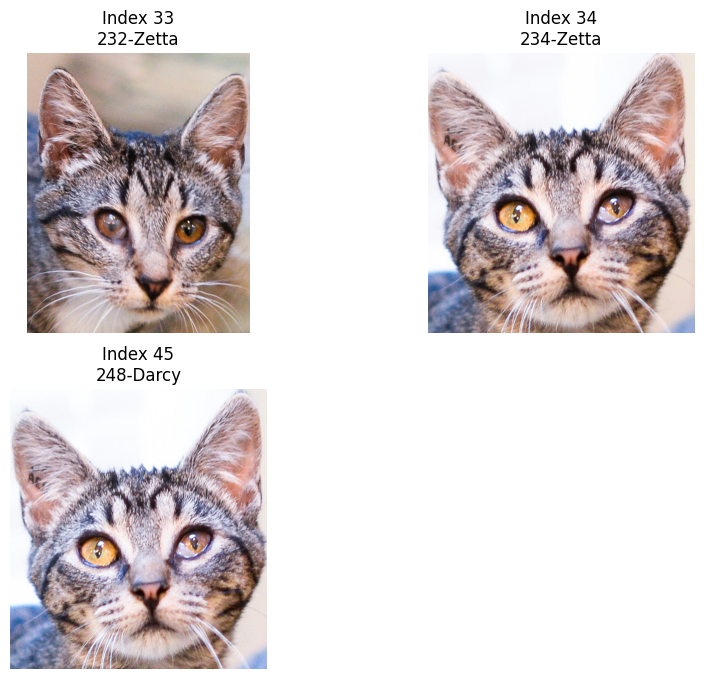

In [ ]:
plot_cluster(1)

In [ ]:
df['cluster_id'].value_counts()[:20]




3     5
10    4
1     3
11    3
7     3
4     3
6     3
5     2
12    2
9     2
2     2
8     2
56    1
50    1
52    1
53    1
49    1
54    1
48    1
47    1
Name: cluster_id, dtype: int64

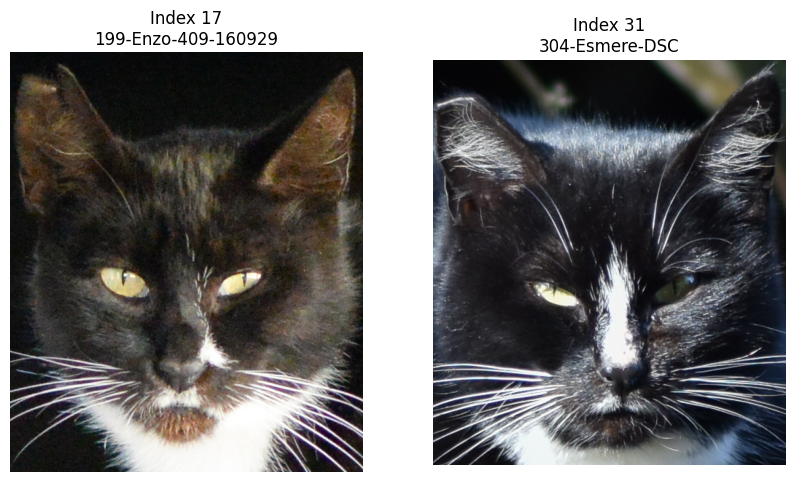

In [ ]:
plot_cluster(12)


